In [29]:
import re
import numpy as np
import pandas as pd
import string
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Masking
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns


# 라벨 데이터 작업
 - No Finding : 특이 점을 찾지 못한 경우
    - 반대의 경우는 특이 점을 찾은 경우 

In [30]:
label_data_path = './data/mimic-cxr-2.0.0-chexpert.csv'

label_data_csv = pd.read_csv(label_data_path)
# 필요 없는 피처 필터링
label_data_filter = label_data_csv.drop(columns=['subject_id', 'Support Devices'])

label_data_filter = label_data_filter.fillna(0)



label_data_noFinding = label_data_filter[['study_id', 'No Finding']]
label_data_noFinding['No Finding'] = label_data_noFinding['No Finding'].fillna(0)

label_data_noFinding['Finding'] = label_data_noFinding['No Finding'].apply(lambda x: 0 if x == 1 else 1)
label_data_Finding = label_data_noFinding[['study_id', 'Finding']]

label_data_Finding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227827 entries, 0 to 227826
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   study_id  227827 non-null  int64
 1   Finding   227827 non-null  int64
dtypes: int64(2)
memory usage: 3.5 MB


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7420\4232206364.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_noFinding['No Finding'] = label_data_noFinding['No Finding'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7420\4232206364.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_noFinding['Finding'] = label_data_noFinding['No Finding'].apply(lambda x: 0 if x == 1 else 1)


# null 값 확인 
 - 50%가 넘는 데이터가 남게 됨 (impression, findings)
 - 11,000 여개 정도의 데이터가 남게 되며 위를 학습시켜도 무난할 것이라 예상 

In [31]:
ehr_csv_data_path = './data/findings_and_impression.csv'

ehr_data_csv = pd.read_csv(ehr_csv_data_path)

cnt = 0
for i in range(len(ehr_data_csv)):
    if pd.isnull(ehr_data_csv['Findings'].iloc[i]) or pd.isnull(ehr_data_csv['Impression'].iloc[i]):
        cnt += 1

print(cnt)

10464


# 널 값이 있는 행을 제거

In [32]:
ehr_data_csv_filtered = ehr_data_csv.dropna()

merge_data_frame = pd.merge(ehr_data_csv_filtered, label_data_Finding, on="study_id")

merge_data_frame[['study_id', 'Finding']]

,study_id,Finding
0,50414267,0
1,53189527,0
2,53911762,0
3,56699142,0
4,57375967,1
...,...,...
11720,56459556,1
11721,57060480,0
11722,52257272,0
11723,52341872,0


In [33]:
len(ehr_data_csv_filtered['Findings'])

11725

In [34]:
sentence_length = []

for finding in ehr_data_csv_filtered['Findings']:
    finding_length = len(finding)
    sentence_length.append(finding_length)

sentence_length

[368,
 280,
 304,
 237,
 375,
 273,
 351,
 395,
 671,
 347,
 510,
 662,
 401,
 294,
 227,
 464,
 288,
 408,
 271,
 390,
 432,
 306,
 336,
 204,
 288,
 299,
 393,
 205,
 486,
 193,
 340,
 332,
 161,
 330,
 210,
 372,
 377,
 152,
 464,
 332,
 190,
 338,
 291,
 188,
 122,
 181,
 197,
 266,
 187,
 314,
 267,
 950,
 458,
 284,
 400,
 255,
 153,
 544,
 471,
 352,
 440,
 649,
 281,
 217,
 491,
 445,
 564,
 422,
 507,
 320,
 357,
 266,
 297,
 659,
 440,
 487,
 468,
 174,
 427,
 755,
 303,
 673,
 517,
 140,
 425,
 343,
 381,
 336,
 332,
 373,
 473,
 548,
 445,
 382,
 255,
 202,
 321,
 335,
 481,
 242,
 326,
 551,
 301,
 254,
 633,
 337,
 586,
 582,
 300,
 285,
 213,
 312,
 246,
 444,
 317,
 304,
 235,
 325,
 649,
 235,
 603,
 421,
 438,
 225,
 276,
 249,
 421,
 499,
 381,
 403,
 357,
 370,
 243,
 285,
 166,
 192,
 185,
 324,
 271,
 245,
 1214,
 355,
 426,
 340,
 177,
 262,
 286,
 284,
 438,
 459,
 331,
 486,
 188,
 348,
 441,
 693,
 638,
 168,
 415,
 235,
 158,
 244,
 272,
 289,
 156,
 335,
 60

In [35]:
findings_lst = []
ehr_data_csv_filtered['Findings'].astype('str')
for string in ehr_data_csv_filtered['Findings']:
    findings_lst.append(string)

impression_lst = []
ehr_data_csv_filtered['Impression'].astype('str')
for string in ehr_data_csv_filtered['Impression']:
    impression_lst.append(string)

print(findings_lst[0], end='\n')
print()
print(impression_lst[0])


There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
 nodular opacities that most likely represent nipple shadows. The
 cardiomediastinal silhouette is normal.  Clips project over the left lung,
 potentially within the breast. The imaged upper abdomen is unremarkable.
 Chronic deformity of the posterior left sixth and seventh ribs are noted.

No acute cardiopulmonary process.


# 데이터 전처리
 - 1. ___ -> name 변수로 치환

In [36]:
# ___ -> name 으로 변환
def replace_data(texts):
    special_char = "___"
    return texts.replace(special_char, "name")


replace_finding_lst = []
for i in range(len(findings_lst)):
    replace_finding_lst.append(replace_data(findings_lst[i]))

replace_impression_lst = []
for i in range(len(impression_lst)):
    replace_impression_lst.append(replace_data(impression_lst[i]))

print(replace_finding_lst[0], end='\n')
print(replace_impression_lst[0])

There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
 nodular opacities that most likely represent nipple shadows. The
 cardiomediastinal silhouette is normal.  Clips project over the left lung,
 potentially within the breast. The imaged upper abdomen is unremarkable.
 Chronic deformity of the posterior left sixth and seventh ribs are noted.
No acute cardiopulmonary process.


In [37]:
type(replace_finding_lst)

list

# 정규식 표현을 통한 특수문자 제거

In [38]:
# 모든 텍스트 소문자변환, 특수문자 정규표현식을 제거
def re_text_preprocessing(lst):
     re_cleaned_list = []
     for text in lst:
          text = text.lower()
          words = text.split()
          refine_text = ""
          for word in words:
               refine_text += word + ' '
          re_cleaned_text = re.sub(r'[^\w\s]', '', refine_text)
          re_cleaned_list.append(re_cleaned_text)
     return re_cleaned_list

replace_finding_lst = re_text_preprocessing(replace_finding_lst)

print(replace_finding_lst[0])

there is no focal consolidation pleural effusion or pneumothorax bilateral nodular opacities that most likely represent nipple shadows the cardiomediastinal silhouette is normal clips project over the left lung potentially within the breast the imaged upper abdomen is unremarkable chronic deformity of the posterior left sixth and seventh ribs are noted 


### 불용어 제거
    - 불용어가 제거된 것을 확인할 수 있음

In [39]:
# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(texts):
    rm_sw_text = ""
    words = texts.split()
    filtered_text = ""
    for word in words:
        if word not in stop_words:
            filtered_text += word + ' '
    rm_sw_text += filtered_text
    return rm_sw_text 

replace_finding_lst_v2 = []
for idx in range(len(replace_finding_lst)):
    replace_finding_lst_v2.append(remove_stopwords(replace_finding_lst[idx]))
# 완성된 문장 집합
print("불용어 제거 전 : ", replace_finding_lst[0])
print("불용어 제거 후 : ", replace_finding_lst_v2[0])

불용어 제거 전 :  there is no focal consolidation pleural effusion or pneumothorax bilateral nodular opacities that most likely represent nipple shadows the cardiomediastinal silhouette is normal clips project over the left lung potentially within the breast the imaged upper abdomen is unremarkable chronic deformity of the posterior left sixth and seventh ribs are noted 
불용어 제거 후 :  focal consolidation pleural effusion pneumothorax bilateral nodular opacities likely represent nipple shadows cardiomediastinal silhouette normal clips project left lung potentially within breast imaged upper abdomen unremarkable chronic deformity posterior left sixth seventh ribs noted 


# 단어 토큰화

### 사전 학습된 토크나이저 사용
 - 참고 레퍼런스 : https://wikidocs.net/166801
 - 트레인 셋과 테스트 셋 분할
 - 사전 학습 토큰화의 단어 어휘 개수 : 28996

In [40]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# 의료계에서 사용하는 토큰화 모델
tokenizer_model_name = 'dmis-lab/biobert-base-cased-v1.2'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)
vocab_size = tokenizer.vocab_size

print(vocab_size)
'''
# 사용 데이터 토크나이징
encoded_inputs = tokenizer(replace_finding_lst_v2, return_tensors='np', padding=True, truncation=True)
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
'''

c:\Users\Administrator\AppData\Roaming\Python\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


28996


"\n# 사용 데이터 토크나이징\nencoded_inputs = tokenizer(replace_finding_lst_v2, return_tensors='np', padding=True, truncation=True)\ninput_ids = encoded_inputs['input_ids']\nattention_mask = encoded_inputs['attention_mask']\n"

### 토큰화된 문장들 텐서로 변환
 - 문장들 텐서로 변환 시킨 것을 input
 - Finding 피처를 label
### 시퀀스분석
 - 문장 시퀀스화 할 경우 최대 길이 = 1472
  - maxlen = 1500

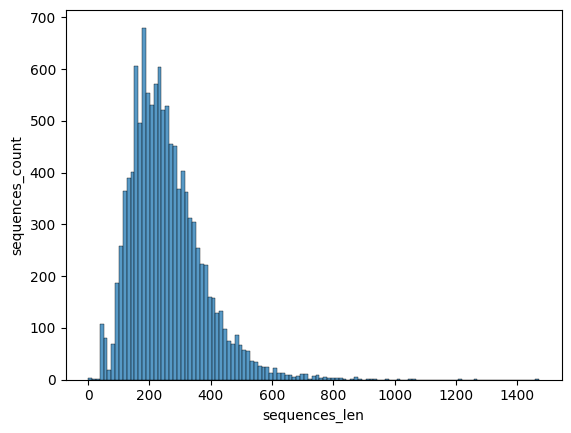

7
1472


In [41]:
tokens_list = []
for text in replace_finding_lst_v2:
    tokens = tokenizer.encode(text, truncation=True, padding='max_length', max_length=512)
    tokens_list.append(tokens)

tokens_len = []
for text_len in replace_finding_lst_v2:
    tokens_len.append(len(text_len))

sns.histplot(data=tokens_len)
plt.xlabel('sequences_len')
plt.ylabel('sequences_count')
plt.show()

cnt = 0
for data in tokens_len:
    if data > 1000:
        cnt += 1

print(cnt)
print(max(tokens_len))

max_len = 1500

### 입력값 확인

In [42]:
tokens_padded = pad_sequences(tokens_list, maxlen=max_len)

input_value = tokens_padded

# target
label = merge_data_frame['Finding']

print(input_value.shape, label.shape)

(11725, 1500) (11725,)


# 트레인, 검증 셋 분리

In [46]:
seed = 42

input_train, input_test, label_train, label_test = train_test_split(input_value, label, test_size=0.2, random_state=seed)  

print(input_train.shape, input_test.shape, label_train.shape, label_test.shape)

(9380, 1500) (2345, 1500) (9380,) (2345,)


# LSTM 모델 클래스 정의
 - 참고 레퍼런스 https://keras.io/api/layers/recurrent_layers/lstm/

In [44]:
class medical_LSTM(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, lstm_units, dense_input_dim, dense_output_dim, dropout_rate, l2_reg_rate):
        super(medical_LSTM, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embedding_units)

        self.first_lstm = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, return_sequences=True))

        self.last_lstm = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, return_sequences=False))

        self.dropout = Dropout(dropout_rate)
        
        self.batch_normalization = BatchNormalization()

        self.first_dense = Dense(dense_input_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg_rate))

        self.last_dense = Dense(dense_output_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l2_reg_rate))
    
    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)

        embedding_output = self.embedding_layer(inputs)

        first_lstm_output = self.first_lstm(embedding_output)

        last_lstm_output = self.last_lstm(first_lstm_output)

        dropout_output = self.dropout(last_lstm_output)

        normalized_output = self.batch_normalization(dropout_output)

        first_dense_outputs = self.first_dense(normalized_output)

        last_dense_outputs = self.last_dense(first_dense_outputs)

        return last_dense_outputs       

In [45]:
'''
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001)

def build_model(hp):
    model = medical_LSTM(
        vocab_size=vocab_size,
        embedding_units=hp.Int('embedding_units', min_value=32, max_value=128, step=32),
        lstm_units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        dense_input_dim=hp.Int('dense_input_dim', min_value=32, max_value=256, step=32),
        dense_output_dim=1,
        dropout_rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.01),
        l2_reg_rate=hp.Float('l2_reg_rate', min_value=0.001, max_value=0.01, step=0.001)
    )
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    directory='hyperband',
    project_name='medical_LSTM'
)

tuner.search(input_train, label_train, epochs=3, validation_data=(input_test, label_test))
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"embedding 유닛 수 : {best_hp.get('embedding_units')}")
print(f"lstm 유닛 수 : {best_hp.get('lstm_units')}")
print(f"완전 밀집층 차원 수 : {best_hp.get('dense_input_dim')}")
print(f"dropout_rate : {best_hp.get('dropout_rate')}")
print(f"l2_reg_rate : {best_hp.get('l2_reg_rate')}")
'''

Reloading Tuner from hyperband\medical_LSTM\tuner0.json


KeyError: 'embedding_units does not exist.'

#### lstm 모델 

In [47]:
class sub_lstm(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, lstm_units):
        super(sub_lstm, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embedding_units)

        self.lstm_layer = LSTM(lstm_units)

        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)

        x = self.embedding_layer(inputs)

        x = self.lstm_layer(x)

        outputs = self.output_layer(x)

        return outputs            

#### 하이퍼 파라미터 튜닝

In [ ]:
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.01)

def build_md(hyperband):
    model = sub_lstm(
        vocab_size = vocab_size,
        embedding_units = hyperband.Int('embedding_units', min_value=32, max_value=128, step=32),
        lstm_units = hyperband.Int('lstm_units', min_value=32, max_value=128, step=32),
    )
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

searching = Hyperband(
    hypermodel = build_md,
    objective = 'val_accuracy',
    max_epochs = 3,
    seed = seed,
    directory = 'hyperband',
    project_name = 'sub_lstm'
)

searching.search(input_train, label_train, epochs=3, validation_data=(input_test, label_test))
best_params = searching.get_best_hyperparameters(num_trials=1)[0]

print(f"임베딩 유닛 개수 : {best_params.get('embedding_units')}")
print(f"lstm 유닛 개수 : {best_params.get('lstm_units')}")

Trial 6 Complete [00h 00m 51s]
val_accuracy: 0.5206822752952576

Best val_accuracy So Far: 0.5206822752952576
Total elapsed time: 00h 02m 52s
임베딩 유닛 개수 : 96
lstm 유닛 개수 : 32


#### 모델 빌드 및 구조

In [ ]:
embedding_units = 96
lstm_units = 32

sub_model = sub_lstm(
    vocab_size= vocab_size,
    embedding_units= embedding_units,
    lstm_units= lstm_units
)

sub_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
sub_model.build(input_shape=input_train.shape)
sub_model.summary()

Model: "sub_lstm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  2783616   
                                                                 
 lstm_2 (LSTM)               multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
Total params: 2,800,161
Trainable params: 2,800,161
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=3)
sub_model.fit(x = input_train, 
              y = label_train,
              validation_data=(input_test, label_test),
              epochs=20,
              callbacks=earlystop)

Epoch 1/20
294/294 [==============================] - 14s 47ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6924 - val_accuracy: 0.5207
Epoch 2/20
294/294 [==============================] - 14s 48ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6924 - val_accuracy: 0.5207
Epoch 3/20
294/294 [==============================] - 13s 46ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6923 - val_accuracy: 0.5207
Epoch 4/20
294/294 [==============================] - 14s 46ms/step - loss: 0.6929 - accuracy: 0.5152 - val_loss: 0.6924 - val_accuracy: 0.5207
Epoch 5/20
294/294 [==============================] - 13s 46ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6925 - val_accuracy: 0.5207
Epoch 6/20
294/294 [==============================] - 13s 46ms/step - loss: 0.6927 - accuracy: 0.5152 - val_loss: 0.6925 - val_accuracy: 0.5207


# 모델 컴파일
 - 최적화 도구 adam learning_rate = 0.01
 - 콜백함수 레퍼런스 : https://deep-deep-deep.tistory.com/1 

In [ ]:
lstm_units = 256
word_size = tokenizer.vocab_size
dense_input_dim = 96
final_output_dim = 1
dropout_rate = 0.0

model = medical_LSTM(
            lstm_units = lstm_units, 
            dense_input_dim = dense_input_dim, 
            dense_output_dim = final_output_dim,
            dropout_rate= dropout_rate,
            l2_reg_rate=0.0041)

model.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약

In [ ]:
model.build(input_shape=(input_train.shape))
model.summary()

Model: "medical_lstm_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  multiple                 528384    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  multiple                 1574912   
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 batch_normalization_7 (Batc  multiple                 2048      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            multiple                  49248     
                                                    

# 모델 학습

In [ ]:
batch_size = 32
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

record = model.fit(
    input_train,
    label_train,
    epochs = 50,
    batch_size = batch_size,
    validation_split = 0.2,
)

Epoch 1/50
235/235 [==============================] - 27s 107ms/step - loss: 1.0871 - accuracy: 0.6069 - val_loss: 0.9885 - val_accuracy: 0.4835
Epoch 2/50
235/235 [==============================] - 24s 101ms/step - loss: 0.8364 - accuracy: 0.6627 - val_loss: 1.2002 - val_accuracy: 0.4835
Epoch 3/50
235/235 [==============================] - 24s 102ms/step - loss: 0.7377 - accuracy: 0.6635 - val_loss: 0.8148 - val_accuracy: 0.4877
Epoch 4/50
235/235 [==============================] - 24s 101ms/step - loss: 0.6790 - accuracy: 0.6763 - val_loss: 0.8406 - val_accuracy: 0.4851
Epoch 5/50
235/235 [==============================] - 24s 102ms/step - loss: 0.6432 - accuracy: 0.6890 - val_loss: 0.9879 - val_accuracy: 0.4851
Epoch 6/50
235/235 [==============================] - 24s 102ms/step - loss: 0.6204 - accuracy: 0.6924 - val_loss: 0.7794 - val_accuracy: 0.4851
Epoch 7/50
235/235 [==============================] - 24s 102ms/step - loss: 0.6134 - accuracy: 0.6891 - val_loss: 0.7552 - val_ac